In [1]:
# 1. Create dummy or indicator features for categorical variables
# 2. Split your data into testing and training datasets
# 3. Standardize the magnitude of numeric features using a scaler

# Capstone 2 Preprocessing
## NBA Salary Predictor and Trade Suggestion
## Austin Cody
From previous notebook we learned that our best features are age, points_pg, 3_pointers_pg, 2_pointers_pg, free_throws_pg, assists_pg, and minutes_pg.
Domain knowledge let's us avoid multicollinearity by removing all attempts columns, field_goals_pg, and turnovers_pg as features that came up previously to avoid multicollinearity.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# increasing the number of displayable columns to better examine all dummy variables 
pd.set_option('display.max_columns', 63)
pd.set_option('display.max_rows', 63)

In [3]:
df = pd.read_csv('nba_salaries_cleaned.csv')

In [4]:
df.head(3)

,name,salary,position,age,team,games_played,games_started,minutes_pg,field_goals_pg,field_goal_attempts_pg,field_goal_%,3_pointers_pg,3_point_attempts_pg,3_point_%,2_pointers_pg,2_point_attempts_pg,2_point_%,effective_field_goal_%,free_throws_pg,free_throw_attempts_pg,free_throw_%,o_rebounds_pg,d_rebounds_pg,total_rebounds_pg,assists_pg,steals_pg,blocks_pg,turnovers_pg,personal_fouls_pg,points_pg
0,Stephen Curry,48070014,['PG'],34,['GSW'],56,56,34.7,10.0,20.2,0.493,4.9,11.4,0.427,5.1,8.8,0.579,0.614,4.6,5.0,0.915,0.7,5.4,6.1,6.3,0.9,0.4,3.2,2.1,29.4
1,John Wall,47345760,['PG'],32,['LAC'],34,3,22.2,4.1,9.9,0.408,1.0,3.2,0.303,3.1,6.7,0.459,0.457,2.3,3.3,0.681,0.4,2.3,2.7,5.2,0.8,0.4,2.4,1.7,11.4
2,Russell Westbrook,47080179,['PG'],34,"['LAL', 'LAC']",73,24,29.1,5.9,13.6,0.436,1.2,3.9,0.311,4.7,9.7,0.487,0.481,2.8,4.3,0.656,1.2,4.6,5.8,7.5,1.0,0.5,3.5,2.2,15.9


## Dummy Variable Creation
1. converting categorical data into lists because some rows belong to multiple classes in each category
2. creating dummy variables
3. concatenating dummy variables to our original dataframe and removing the original categorical columns

In [5]:
# our categorical variables were an issue before due to the conversion of list objects to strings
# during the dataframe to .csv process.
print(type(df['position'].iloc[0]), type(df['team'].iloc[0]))

<class 'str'> <class 'str'>


In [6]:
# converting strings back into lists
# eval() function concisely converts strings formatted as '['team1','team2']' back into a list object
df['position'] = df['position'].apply(eval)
df['team'] = df['team'].apply(eval)

In [7]:
# confirming our position and team columns are now list objects
print(type(df['position'].iloc[0]), type(df['team'].iloc[0]))

<class 'list'> <class 'list'>


In [8]:
# because each category is a list I need to handle pd.get_dummies differently:
# 1. turn the list objects into Series
# 2. stack it to change it from wide format to long format
# 3. adding team prefix (this part is standard)
# 4. groupby(level=0) gets around the multi indexing
team_dummies = pd.get_dummies(df['team'].apply(pd.Series).stack(), prefix='team').groupby(level=0).sum()

In [9]:
# finding player with 2 positions and 2 teams for verification of dummy variables
df[df['name'] == 'Mikal Bridges'][['name','position','team']]
# noting index of 58

,name,position,team
58,Mikal Bridges,"[SF, SG]","[BRK, PHO]"


In [10]:
# examining 58th index -> player whom we know has multiple teams
# you can see this was successful because multiple 1s appear in the third row for LAC and LAL
print(team_dummies.iloc[58][['team_BRK','team_PHO']])
team_dummies.head(3)

team_BRK    1
team_PHO    1
Name: 58, dtype: int64


,team_ATL,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_UTA,team_WAS
0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [11]:
# repeating for position
position_dummies = pd.get_dummies(df['position'].apply(pd.Series).stack(), prefix='position').groupby(level=0).sum()
print(position_dummies.iloc[58][['position_SF','position_SG']])
position_dummies.head(3)

position_SF    1
position_SG    1
Name: 58, dtype: int64


,position_C,position_PF,position_PG,position_SF,position_SG
0,0,0,1,0,0
1,0,0,1,0,0
2,0,0,1,0,0


In [12]:
#concatenating with original dataframe and dropping original categorical columns:
df_dummies = pd.concat([df, position_dummies, team_dummies], axis=1)
df_dummies = df_dummies.drop(['position','team'], axis=1)

In [13]:
# looks good
df_dummies[df_dummies['name'] == 'Mikal Bridges']

,name,salary,age,games_played,games_started,minutes_pg,field_goals_pg,field_goal_attempts_pg,field_goal_%,3_pointers_pg,3_point_attempts_pg,3_point_%,2_pointers_pg,2_point_attempts_pg,2_point_%,effective_field_goal_%,free_throws_pg,free_throw_attempts_pg,free_throw_%,o_rebounds_pg,d_rebounds_pg,total_rebounds_pg,assists_pg,steals_pg,blocks_pg,turnovers_pg,personal_fouls_pg,points_pg,position_C,position_PF,position_PG,position_SF,position_SG,team_ATL,team_BOS,team_BRK,team_CHI,team_CHO,team_CLE,team_DAL,team_DEN,team_DET,team_GSW,team_HOU,team_IND,team_LAC,team_LAL,team_MEM,team_MIA,team_MIL,team_MIN,team_NOP,team_NYK,team_OKC,team_ORL,team_PHI,team_PHO,team_POR,team_SAC,team_SAS,team_TOR,team_UTA,team_WAS
58,Mikal Bridges,20100000,26,83,83,35.7,7.1,15.3,0.468,2.0,5.3,0.382,5.1,9.9,0.514,0.535,3.8,4.3,0.895,1.0,3.4,4.4,3.3,1.1,0.7,1.5,1.9,20.1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [19]:
# saving data frame for use in modeling notebook
df_dummies.to_csv('nba_salaries_dummies.csv', index=False)

## Splitting Data into Train/Test Data

In [14]:
# features from previous notebook
features = ['age','2_pointers_pg','3_pointers_pg','free_throws_pg','assists_pg','points_pg', 'minutes_pg']

X = df_dummies[features].values
y = df_dummies['salary'].values

# we don't need to stratify because this data is necessarily balanced
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=12)

## Scaling Features

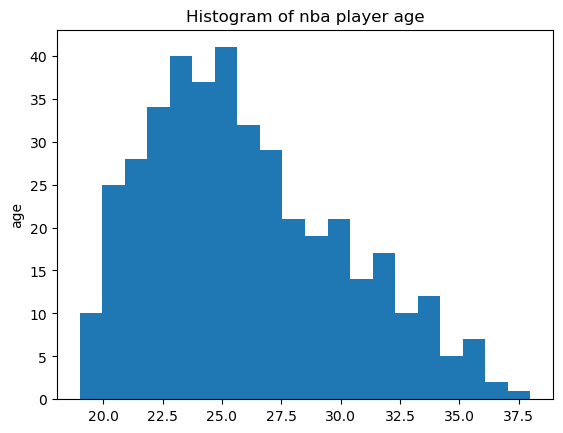

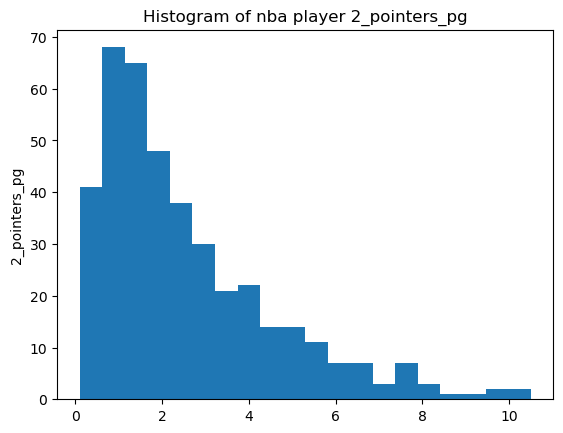

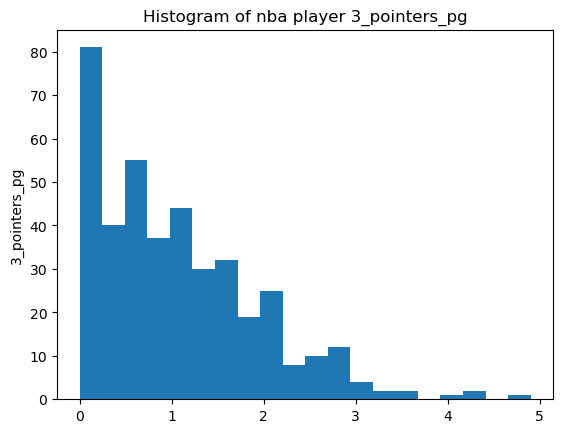

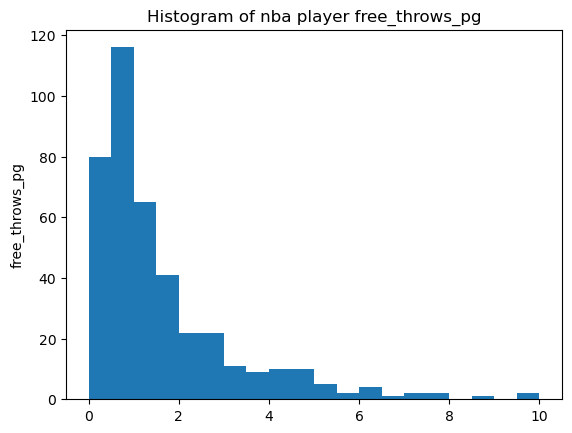

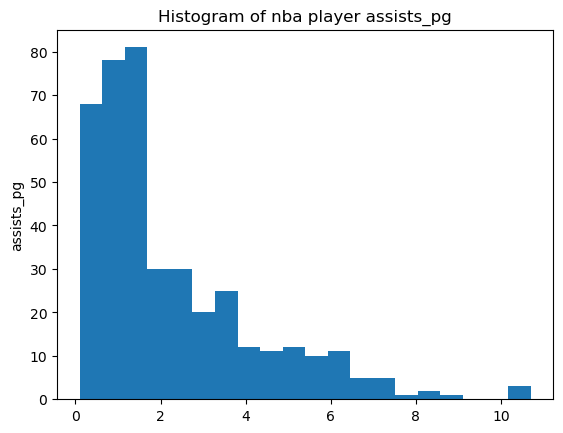

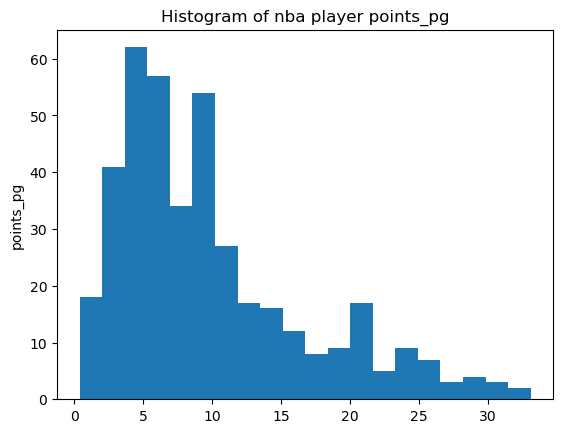

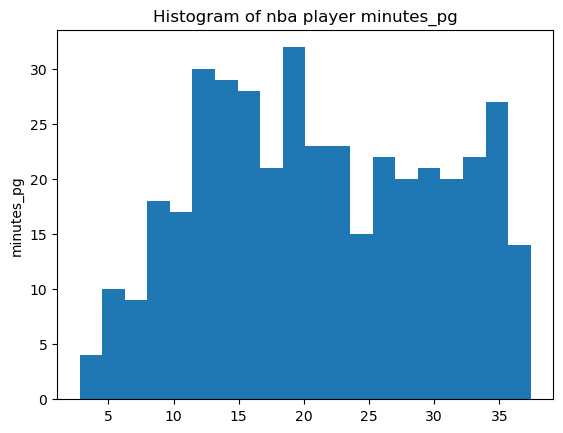

In [15]:
# features from previous notebook
for i in features:
    plt.hist(df[i], bins=20)
    plt.ylabel('{}'.format(i))
    plt.title('Histogram of nba player {}'.format(i))
    plt.show()

#since the data is right skewed I think a log transformation using PowerTransformer() would be best

In [16]:
from sklearn.preprocessing import PowerTransformer, StandardScaler

# transforming data using a log transformation
log = PowerTransformer()
X_train_logged = log.fit_transform(X_train)
X_test_logged = log.transform(X_test)

#trying with a standard scaler too
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Testing
Just to see if the scaling worked at all. Outside the scope of this notebook we'll do better modeling

In [17]:
#testing with a basic linear regression model on POWER TRANSFORMED data
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train_logged, y_train)

y_pred = lin_reg.predict(X_test_logged)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'Root Mean Squared Error: {rmse}')
r2 = r2_score(y_test, y_pred)
print(f'R-squared: {r2}')

Root Mean Squared Error: 7939877.709871792
R-squared: 0.5335573419225739


In [18]:
#testing with a basic linear regression model on STANDARD SCALED data
lin_reg2 = LinearRegression()
lin_reg2.fit(X_train_scaled, y_train)

y_pred2 = lin_reg2.predict(X_test_scaled)

rmse2 = np.sqrt(mean_squared_error(y_test, y_pred2))
print(f'Root Mean Squared Error: {rmse2}')
r2_2 = r2_score(y_test, y_pred2)
print(f'R-squared: {r2_2}')

Root Mean Squared Error: 7464872.742052903
R-squared: 0.5876979904530617


## Conclusion
### I would have assumed that using a PowerTransformer()  would be a better preprocessing technique in this case because all but one of our features are right skewed, however it appears that using a standard scaler increased model performance by 5%. Looking forward to trying out different models and making better and better predictions in the next notebook.